# Rozwiązywanie układów równań liniowych
## Laboratorium 2 - Metody Obliczeniowe w Nauce i Technice

In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime

## Zadanie 1. Eliminacja Gaussa-Jordana.

In [4]:
# Gauss-Jordan elimination algorithm with partial pivoting
def gauss_jordan(A):
    n = len(A)
    m = len(A[0])
    h = k = 0

    while h < n and k < m:
        id_max = max([(abs(A[i][k]), i) for i in range(h, n)])[1]
        if A[id_max][k] == 0: k += 1
        else:
            A[[h, id_max]] = A[[id_max, h]]
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                for j in range(k + 1, m): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return A


# Backward substitution
def backward_substitution(A):
    n = len(A)
    m = len(A[0])
    
    for h in range(n - 1, -1, -1):
        A[h][m - 1] *= 1 / A[h][h]
        A[h][h] = 1
        for i in range(h - 1, -1, -1):
            f = A[i][h]
            A[i][h] = 0
            for j in range(h + 1, m): A[i][j] -= f * A[h][j]
            
    return A


# Linear solver
def lin_solve(A, y):
    n = len(A)
    Ay = np.hstack((A, np.array([[x] for x in y])))
    Ay = backward_substitution(gauss_jordan(Ay))
    
    return np.array([x[n] for x in Ay])

In [ ]:
dimensions = np.array([
    (510, 510),
    (520, 520),
    (530, 530),
    (540, 540),
    (550, 550),
    (600, 600),
    (650, 650),
    (700, 700),
    (750, 750),
    (800, 800),
    (1000, 1000)
])

# Tests
for n, m in dimensions:
    print(f"N = {n}")
    
    A = np.random.rand(n, m)
    y = np.random.rand(n)
    
    np_start_timestamp = datetime.timestamp(datetime.now())
    np.linalg.solve(A, y)
    print(f"NumPy.linalg.solve():\t\t{datetime.timestamp(datetime.now()) - np_start_timestamp}s")
    
    ls_start_timestamp = datetime.timestamp(datetime.now())
    lin_solve(A, y)
    print(f"Own function, lin_solve():\t{datetime.timestamp(datetime.now()) - np_start_timestamp}s\n")

`np.linalg.solve()` jest zdecydowanie szybsza niż moja funkcja. Dużym usprawnieniem szybkości jest fakt implementacji biblioteki `NumPy` w `C` - chociaż jest dla mnie co najmniej zastawiająca olbrzymia różnica czasu wykonywania obu funkcji, uwzględniając ten fakt.

## Zadanie 2. Faktoryzacja LU.

In [5]:
def lu_decomposition(A):
    n = len(A)
    L = np.zeros((n, n))
    h = k = 0

    while h < n and k < n:
        idx_non_zero = -1
        for i in range(h, n):
            if A[i][k] != 0:
                idx_non_zero = i
                break
                
        if idx_non_zero < 0: k += 1
        else:
            A[[h, idx_non_zero]] = A[[idx_non_zero, h]]
            L[h][h] = 1
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                L[i][h] = f
                for j in range(k + 1, n): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return L, A

In [6]:
A = np.array([[1,2,3],[5,8,-4],[3,-2,7]])
L, U = lu_decomposition(np.copy(A))
L, U

(array([[1., 0., 0.],
        [5., 1., 0.],
        [3., 4., 1.]]),
 array([[  1,   2,   3],
        [  0,  -2, -19],
        [  0,   0,  74]]))

Poprawność algorytmu dekompozycji $LU$, można sprawdzić obliczając $||A - LU||_1 = 0$

In [7]:
# Matrix norm of A - LU inducted by vector 1-norms
np.max((np.abs(A - np.dot(L, U))).sum(axis=1))

0.0

## Zadanie 3. Analiza obwodu elektrycznego - nadokreślony układ równań.

### Wczytywanie listy krawędzi grafu z pliku i siły elektromotorycznej SEM

In [8]:
def load_adjacency_list_from_file(path):
    with open(path) as file:
        adj_list = []
        lines = [line.rstrip() for line in file]
        
        for i in range(len(lines)):
            row = line.split(',')
            for j in range(0, len(row), 2):
                adj_list[i].append((int(row[j]), float(row[j + 1])))
                
        return adj_list
    
    return None


# def adjacency_matrix_from_list(G):
#     M = np.zeros((len(G), len(G)))
#     for i in range(len(G)):
#         for j, w in G[i]:
#             M[i][j] = w
            
#     return M
    

def load_emf():
    s, t, E = input("Type electromotive force E from s to v vertices (s t E): ").split()
    return int(s), int(t), float(E)

### Graf $G$ reprezentujący testowy obwód elektryczny

![Test graph](graph-test.jpg)

In [63]:
# Test graph

# G0 = nx.Graph()
# G0.add_weighted_edges_from([
#     (1, 0, 0),
#     (1, 4, 1),
#     (1, 2, 4),
#     (2, 3, 1),
#     (3, 4, 2),
#     (4, 5, 1),
#     (5, 6, 4),
#     (6, 0, 1),
#     (3, 7, 1),
#     (4, 7, 1),
#     (7, 8, 1),
#     (8, 5, 1)
# ])

G = nx.Graph()
G.add_weighted_edges_from([
    (0, 1, 0),
    (1, 2, 6),
    (2, 3, 4),
    (3, 0, 2),
])

s, t, E = 0, 1, 4

In [64]:
def draw_graph(G, weights):
    layout = nx.spring_layout(G, seed=2137)
    
    _min, _max = min(weights.values()), max(weights.values())
    edge_color_intesities = []
    for u, v in G.edges:
        edge_color_intesities.append((weights[(u, v)] - _min) / (_max - _min))
        
    rounded_weights = 
    
    nx.draw(G, pos=layout, edge_color=edge_color_intesities, edge_cmap=mpl.colormaps["plasma"])
    nx.draw_networkx_labels(G, pos=layout, font_color="#f0f0f0")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=weights)

In [66]:
def parse_to_directed(G, s, t):
    if isinstance(G, nx.DiGraph): di_G = G
    else: di_G = G.to_directed()
    cycles = nx.cycle_basis(G)
    
    e_to_remove = {}
    for u, v in di_G.edges:
        if not (v, u) in e_to_remove and di_G.has_edge(v, u):
            e_to_remove[(u, v)] = True
    for u, v in e_to_remove.keys():
        di_G.remove_edge(u, v)
    if di_G.has_edge(t, s):
        E = G[t][s]["weight"]
        di_G.remove_edge(t, s)
        di_G.add_edge(s, t, weight=E)
    for u, v in di_G.edges:
        print((u, v))
    
    
#     # Remove edges based on cycles, which contain s or t node
#     for cycle in cycles:
#         idx, is_t = None, None
#         if t in cycle: idx, is_t = cycle.index(t), True
#         elif s in cycle: idx, is_t = cycle.index(s), False
#         if idx is not None:
#             n = len(cycle)
#             for i in range(n):
#                 v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
#                 if is_t and di_G.has_edge(v, u): di_G.remove_edge(v, u)
#                 elif is_t == False and di_G.has_edge(u, v): di_G.remove_edge(u, v)
     
#     # Remove edges based on other cycles
#     for cycle in cycles:
#         if s not in cycle and t not in cycle:
#             n = len(cycle)
#             idx = None
#             for i in range(n):
#                 v, u = cycle[i % n], cycle[(i - 1) % n]
#                 if di_G.has_edge(v, u) and not di_G.has_edge(u, v):
#                     idx = i
#                     break
                    
#             if idx is None: continue
#             for i in range(n - 1):
#                 v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
#                 if di_G.has_edge(v, u): di_G.remove_edge(v, u)

    return di_G

G = parse_to_directed(G, s, t)
# G = parse_to_directed(G, s, t)

(0, 1)
(2, 1)
(3, 2)
(3, 0)


In [71]:
def fix_directed_graph(G, I):
    e_to_remove = []
    
    for u, v in G.edges:
        if I[(u, v)] < 0:
            e_to_remove.append((u, v))
            I[(v, u)] = -I.pop((u, v))
            
    for u, v in e_to_remove:
        w = G[u][v]["weight"]
        G.remove_edge(u, v)
        G.add_edge(v, u, weight=w)
        
    return G

### I i II prawo Kirchhoffa

Posiadając dany graf skierowany $G = (V, E)$, jesteśmy w stanie uzyskać maksymalnie $V$ równań z I prawa Kirchhoffa, na potrzeby zadania zakładam, że między wierzchołkiem $s$ a $t$ nie istnieje żaden opór. Na początku wybieram potencjalnie $V$ z I prawa Kirchhoffa, jeśli rząd zawiera nie więcej niż 1 współczynnik lub istnieje "zerowa" kolumna, to odpowiednio je usuwam. Po wstępnym stworzeniu macierzy porównuje jej wielkość do rozmiaru grafu $G$, jeśli jest on mniejszy to korzystam z funkcji bibliotecznej `NetworkX` `cycle_basis()` i wyznaczam unikatową bazę cykli. Za jej pomocą jestem w stanie utworzyć kompletny układ równań z II prawa Kirchhoffa i prawa Ohma (jedynym wyjątkiem jest jeśli baza cykli + rozmiar wstępnej macierzy będzie mniejszy od $E$, można to wykonać, łącząc kombinacje poszczególnych elementów bazy, tworząc większe cykle).

{(0, 1): 0, (1, 2): 0.3333333333333333, (2, 3): 0.3333333333333333, (3, 0): 0.33333333333333337}
0 1
1 2
2 3
3 0


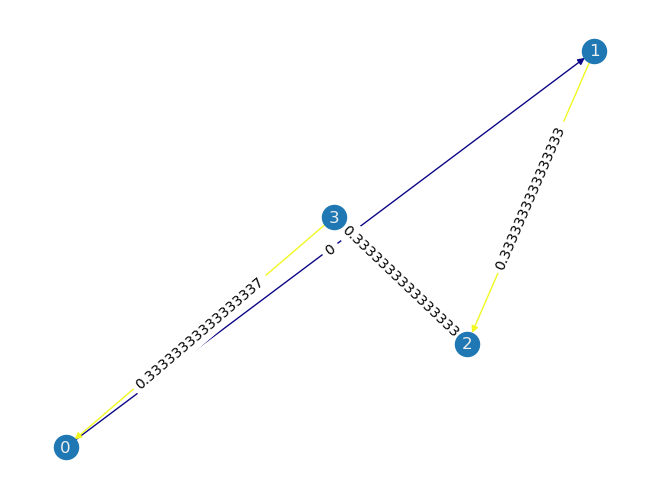

In [79]:
def kirchhoffs_laws(G, s, t, e):
    def reduce_rows(A):
        idxs, eps = [], 10**-9
        for i in range(len(A)):
            counter = 0
            for j in range(len(A[i])):
                if abs(A[i][j]) > eps:
                    counter += 1
            if counter <= 1:
                idxs.append(i)
                
        A = np.delete(A, idxs, axis=0)
        return A
    
    def reduce_cols(A):
        idxs, eps = [], 10**-9
        for j in range(len(A[0])):
            counter = 0
            for i in range(len(A)):
                if abs(A[i][j]) > eps:
                    counter += 1
            if counter == 0:
                idxs.append(j)
                
        A = np.delete(A, idxs, axis=1)
        return A
        
        
    N = len(G.edges) - 1
    V = len(G)
    
    I = np.zeros((V, N))
    A = np.zeros((N, N))
    B = np.zeros(N)
    
    # Label every edge, which is not equal 0
    i = 0
    edges = {}
    for u, v in G.edges:
        if G[u][v]["weight"] == 0: continue
        edges[(u, v)] = i
        i += 1
    # print(edges)
    
    # The Kirchhoff's current law
    for u, v in G.edges:
        if G[u][v]["weight"] == 0:
            continue
        
        # print(f"({u}, {v})", edges[(u, v)], I[u], len(I), len(I[0]), len(I[1]))
        I[u][edges[(u, v)]] = 1
        I[v][edges[(u, v)]] = -1
    
    # Reduce rows with less or equal than 1 and columns with 0 coefficients
    I = reduce_rows(I)
    if len(I) > N:
        rows = [i for i in range(N, len(I))]
        I = np.delete(I, rows, axis=0)
    if len(I[0]) > N:
        I = reduce_cols(I)
        if len(I[0]) > N:
            cols = [j for j in range(N, len(I[0]))]
            I = np.delete(I, cols, axis=1)
    
    # Set A matrix, if there is more variables than rows, use the Kirchhoff's voltage law
    if len(I) == N and len(I[0]) == N:
        A = I
    # The Kirchhoff's voltage law
    else:
        n, m = len(I), len(I[0])
        C = np.zeros((N - n, N))
        cycles = nx.cycle_basis(G.to_undirected())
        
        # Combine cycle basis and KVL equations
        if len(cycles) + n >= N:
            for i in range(N - n):
                c_len = len(cycles[i])
                cycle_edges = [(cycles[i][j % c_len], cycles[i][(j + 1) % c_len]) for j in range(c_len)]
                for u, v in cycle_edges:
                    if u != s and v != t:
                        C[i][edges[(u, v)]] = -G[u][v]["weight"]
                    else:
                        B[i + n] = -e
            if m < N:
                I = np.hstack((I, np.zeros(n, N - m)))
                        
            A = np.vstack((I, C))
            
        # Extend cycles using basis
        else:
            # Combine cycle basis
            print(len(cycles), n, N)
            pass
    
    I = np.linalg.solve(A, B)
    
    res = {}
    for u, v in G.edges:
        if (u, v) in edges:
            res[(u, v)] = I[edges[(u, v)]]
        else:
            res[(u, v)] = 0
    
    return res
    
    
I = kirchhoffs_laws(G, s, t, E)
draw_graph(fix_directed_graph(G, I), I)

### Metoda potencjałów węzłowych

Posiadając dany graf skierowany $G = (V, E)$ można uzyskać $V$ równań napięcia. Wykorzystując metodę potencjałów węzłowych jestem w stanie obliczyć napięcie w każdym wierzchołku grafu $G$, a następnie z prawa Ohma natężenie w każdym odcinku obwodu.

{(0, 1): 0, (1, 2): 0.3333333333333333, (2, 3): 0.3333333333333333, (3, 0): 0.33333333333333337}
{(0, 1): 0, (1, 2): 0.3333333333333333, (2, 3): 0.3333333333333333, (3, 0): 0.33333333333333337}
0 1
1 2
2 3
3 0


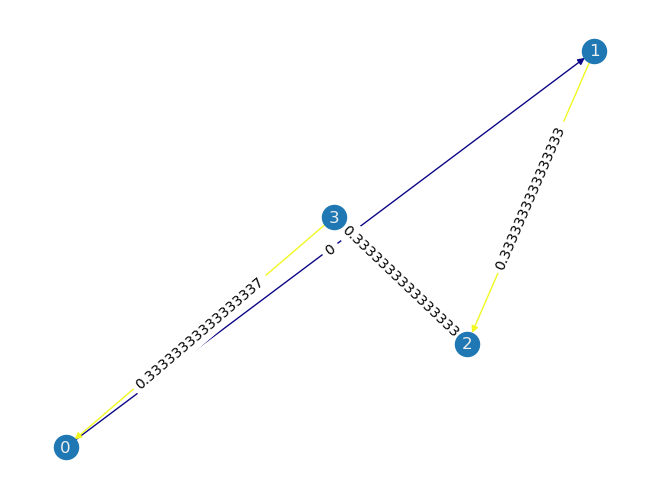

In [80]:
def branch_current_method(G, s, t, e):
    N = len(G)
    
    A = np.zeros((N, N))
    B = np.zeros(N)
    
    V = np.full(N, None)
    V[s] = 0
    V[t] = e
    
    for u in range(N):
        # Out (+I_k)
        for v in [v for v in G.neighbors(u)]:
            w = G[u][v]["weight"]
            if w == 0:
                continue
            
            if V[u] is None: A[u][u] += 1 / w
            else: B[u] -= V[u] / w
            if V[v] is None: A[u][v] -= 1 / w
            else: B[u] += V[v] / w
            
        # In (-I_k)
        for v in range(N):
            if not G.has_edge(v, u) or G[v][u]["weight"] == 0:
                continue
            w = G[v][u]["weight"]
            
            if V[u] is None: A[u][u] += 1 / w
            else: B[u] -= V[u] / w
            if V[v] is None: A[u][v] -= 1 / w
            else: B[u] += V[v] / w
    
    # Remove unnecessary rows and columns, avoiding det(A) = 0
    A = np.delete(A, (s, t), 0)
    A = np.delete(A, (s, t), 1)
    B = np.delete(B, (s, t))
    res = np.linalg.solve(A, B)
    
    # Merge together electric potential differences of s and t nodes with others
    j = 0
    for i in range(N):
        if i == s or i == t: continue
        V[i] = res[j]
        j += 1
    
    # Evaluate electric current in every edge of the circuit
    I = {}
    for i, e in enumerate(G.edges):
        u, v = e
        if G[u][v]["weight"] == 0: I[e] = 0
        else: I[e] = (V[u] - V[v]) / G[u][v]["weight"]
    print(I)
    return I
    
I = branch_current_method(G, s, t, E)
draw_graph(fix_directed_graph(G, I), I)
# w = branch_current_method(G, s, t, E)
# for u, v in G.edges: print((u, v, w[(u, v)]))
# nx.draw(G)
# nx.draw(nx.navigable_small_world_graph(4))

In [14]:
def add_weights_to_graph(G, s, t):
    G = parse_to_directed(G, s, t)
    
    for u, v in G.edges:
        G.update(edges=[(u, v, {"weight": np.random.rand() * 11})])
    
    return G

### Spójny graf losowy (Erdős–Rény)

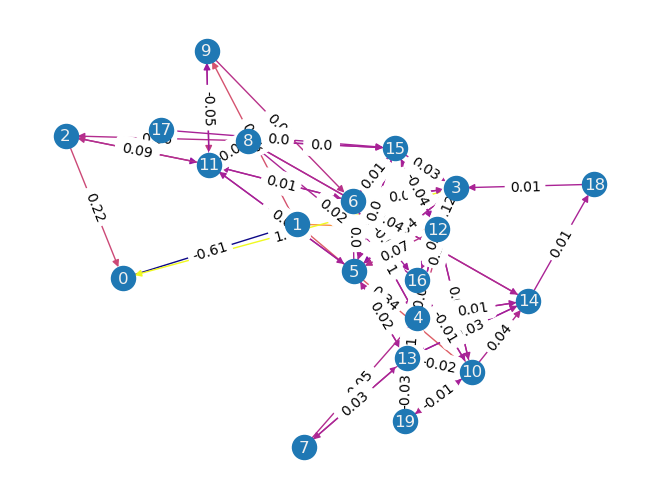

In [15]:
G = add_weights_to_graph(nx.erdos_renyi_graph(20, 0.3), s, t)
draw_graph(G, branch_current_method(G, s, t, E))

### Graf 3-regularny (kubiczny)

In [16]:
G = add_weights_to_graph(nx.random_regular_graph(3, 20), s, t)
draw_graph(G, branch_current_method(G, s, t, E))

LinAlgError: Singular matrix

### Graf złożony z dwóch grafów losowych połaczonych mostkiem

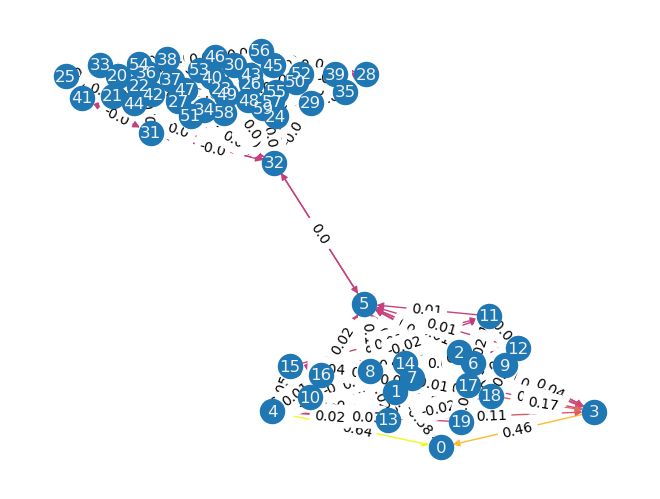

In [17]:
N = 20
G0 = nx.erdos_renyi_graph(N, 0.4)
G1 = nx.erdos_renyi_graph(40, 0.45)
for u, v in [e for e in G1.edges]:
    G1.remove_edge(u, v)
    G1.add_edge(u + N, v + N)
G = nx.compose(G0, G1)
G.add_edge(5, 32)
G = add_weights_to_graph(G, s, t)

# nx.draw(G)
draw_graph(G, branch_current_method(G, s, t, E))

### Graf siatka 2D

In [18]:
# Whoopsie, different representation of grid_2d_graph().edges
G = add_weights_to_graph(nx.grid_2d_graph(32, 16), s, t)
draw_graph(G, kirchhoffs_laws(G, s, t, E))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: 'numpy.float64' object does not support item assignment

### Graf typu small-world

In [ ]:
# Whoopsie, different representation of navigable_small_world_graph().edges
G = add_weights_to_graph(nx.navigable_small_world_graph(32), s, t)
draw_graph(G, kirchhoffs_laws(G, s, t, E))

Jedyną wadą powyższych algorytmów jest błędny algorytm wyznaczania kierunku przepływu prądu w obwodzie (zamiany grafu nieskierowanego $G$ na skierowany), potrafi on rzadko zwrócić krawędź dwukierunkową w wyniku zbyt małej bazy cykli.

(0, 3)
(0, 7)
(0, 8)
(1, 2)
(1, 3)
(1, 4)
(1, 7)
(2, 4)
(3, 4)
(3, 6)
(3, 8)
(4, 9)
(5, 9)
(6, 8)
(7, 8)
